# ***Charge deepxde***

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.1 MB/s eta 0:00:00


# ***Problem definition***

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


m = 1
#m = 2
omega = m * np.pi

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 2)  # for m =1, the problem is 2 periodic
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


def pde(x, y):

    E, H = y[:, 0:1], y[:, 1:2]
    dE_t = dde.grad.jacobian(y, x, i=0, j=1)
    dH_x = dde.grad.jacobian(y, x, i=1, j=0)
    dH_t = dde.grad.jacobian(y, x, i=1, j=1)
    dE_x = dde.grad.jacobian(y, x, i=0, j=0)

    eq1 = dE_t - dH_x
    eq2 = dH_t - dE_x
    return [eq1, eq2]

# boudary (E=0 在 x=0 和 x=1)
def boundary_E(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 1))

bc_E = dde.DirichletBC(geomtime, lambda x: 0, boundary_E, component=0)

# initial (E(x,0) = sin(m*pi*x), H(x,0) = 0)
def initial_E(x):
    return np.sin(m * np.pi * x[:, 0:1])

def initial_H(x):
    return np.zeros_like(x[:, 0:1])

ic_E = dde.IC(geomtime, initial_E, lambda _, on_initial: on_initial, component=0)
ic_H = dde.IC(geomtime, initial_H, lambda _, on_initial: on_initial, component=1)

# Analytical solution
def analy_sol(x):
    E = np.sin(m * np.pi * x[:, 0:1]) * np.cos(omega * x[:, 1:2])
    H = np.cos(m * np.pi * x[:, 0:1]) * np.sin(omega * x[:, 1:2])
    return np.hstack((E, H))


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


# ***Part1 : Training Data Sampling Parameters for 4 layers and 50 neurons and 6000 epochs***
## Trainning1 : num_domain=300, num_boundary=30 num_initial=30, num_test=300

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=300,
    num_boundary=30,
    num_initial=30,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=1000, display_every=500)

NameError: name 'dde' is not defined

# ***Time Evaluation***

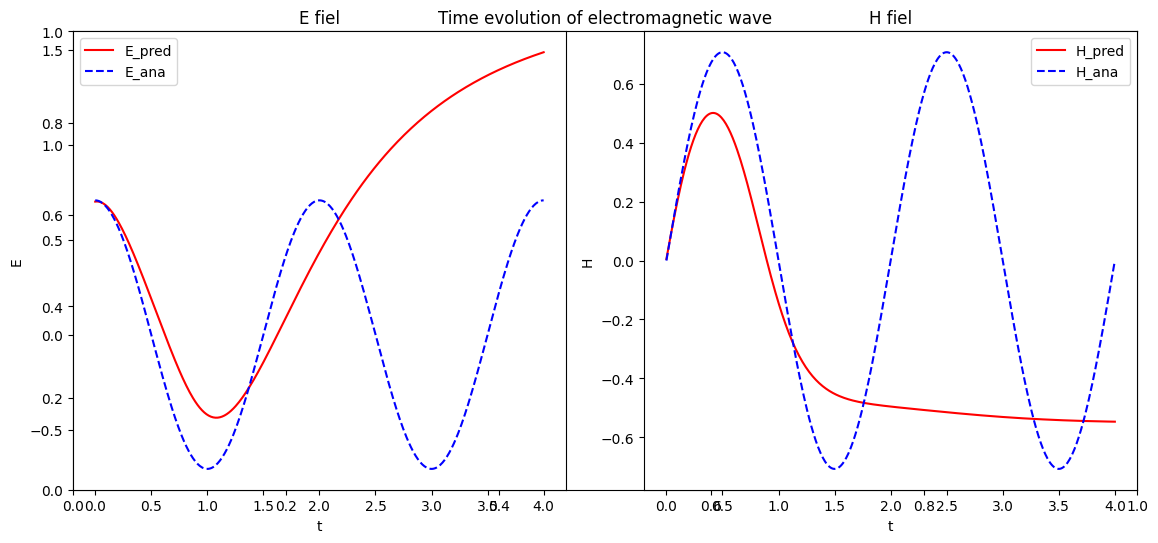

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plort Error

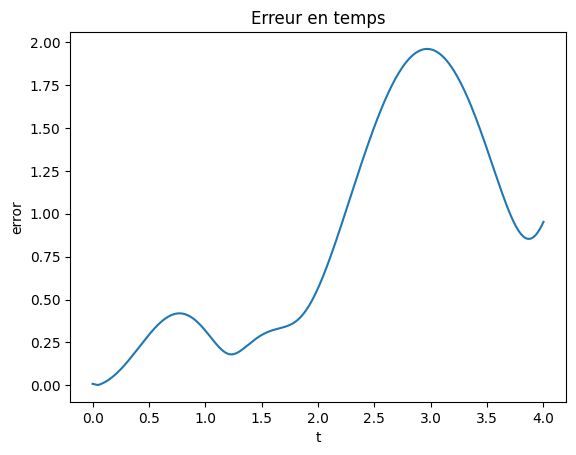

error_max in the trainning domain = [0.55891043]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning2 : num_domain=600, num_boundary=60 num_initial=60, num_test=300

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=600,
    num_boundary=60,
    num_initial=60,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=1000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.169256 s

'compile' took 1.067868 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.12e-02, 1.73e-01, 3.19e-02, 4.44e-01, 3.56e-02]    [4.30e-02, 1.61e-01, 3.19e-02, 4.44e-01, 3.56e-02]    [1.09e+00]    
500       [2.60e-03, 1.66e-03, 1.46e-02, 2.21e-03, 1.18e-03]    [2.84e-03, 1.55e-03, 1.46e-02, 2.21e-03, 1.18e-03]    [4.90e-01]    
1000      [8.01e-04, 9.76e-04, 1.04e-02, 5.53e-04, 7.99e-05]    [9.33e-04, 1.05e-03, 1.04e-02, 5.53e-04, 7.99e-05]    [3.71e-01]    

Best model at step 1000:
  train loss: 1.28e-02
  test loss: 1.30e-02
  test metric: [3.71e-01]

'train' took 9.855556 s



# ***Time Evaluation***

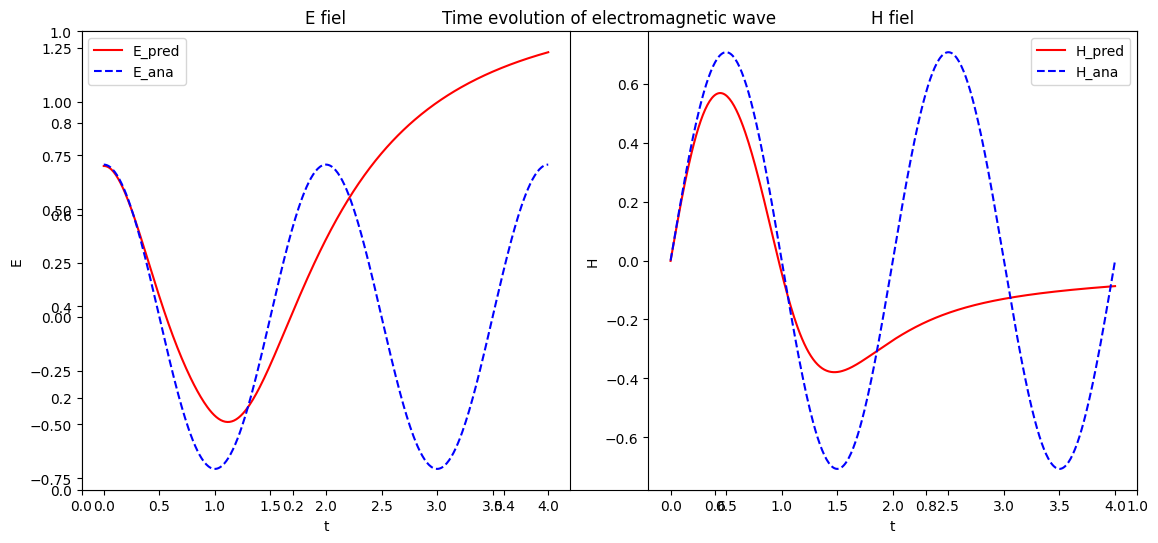

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning3 : num_domain=1000, num_boundary=100 num_initial=60, num_test=300

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=1000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.102989 s

'compile' took 0.819472 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.12e-02, 1.73e-01, 2.98e-02, 4.39e-01, 3.60e-02]    [4.30e-02, 1.61e-01, 2.98e-02, 4.39e-01, 3.60e-02]    [1.07e+00]    
500       [1.95e-03, 1.92e-03, 1.52e-02, 2.79e-03, 1.19e-03]    [2.25e-03, 1.80e-03, 1.52e-02, 2.79e-03, 1.19e-03]    [4.80e-01]    
1000      [1.00e-03, 1.38e-03, 1.13e-02, 6.89e-04, 8.75e-05]    [1.19e-03, 1.45e-03, 1.13e-02, 6.89e-04, 8.75e-05]    [3.52e-01]    

Best model at step 1000:
  train loss: 1.45e-02
  test loss: 1.47e-02
  test metric: [3.52e-01]

'train' took 24.115706 s



# ***Time Evaluation***

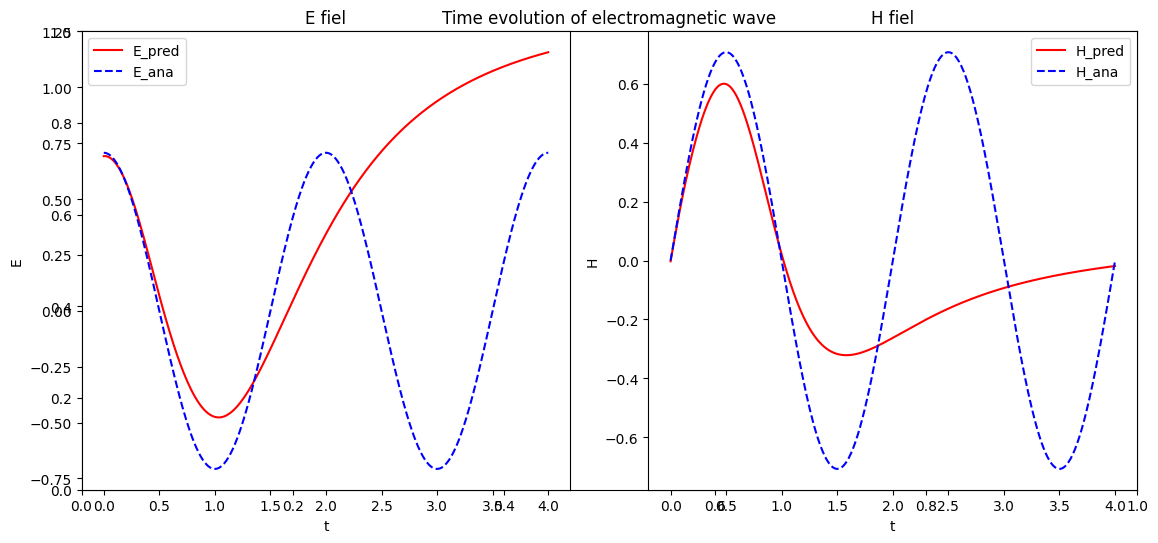

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

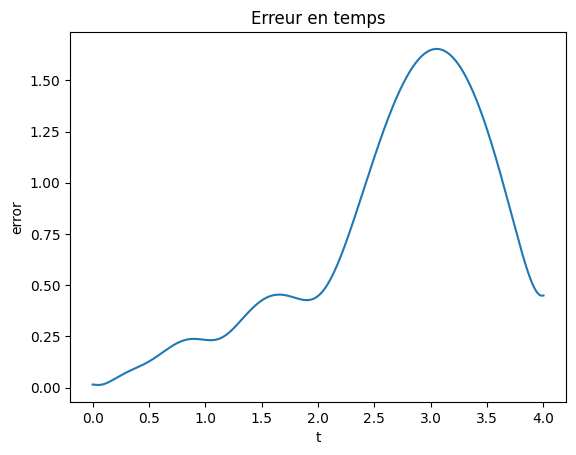

error_max in the trainning domain = [0.45427997]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Part2 : Epochs Trainning num_domain=1000, num_boundary=100 num_initial=100, num_test=300, 4 layers and 50 neurons***
# Trainning1: epochs = 1000

In [ ]:

layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=1000, display_every=500)


Compiling model...
Building feed-forward neural network...
'build' took 0.092617 s

'compile' took 0.707289 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.12e-02, 1.73e-01, 2.94e-02, 4.39e-01, 3.60e-02]    [4.30e-02, 1.61e-01, 2.94e-02, 4.39e-01, 3.60e-02]    [1.08e+00]    
500       [1.88e-03, 1.79e-03, 1.54e-02, 2.80e-03, 1.10e-03]    [2.19e-03, 1.69e-03, 1.54e-02, 2.80e-03, 1.10e-03]    [4.85e-01]    
1000      [9.47e-04, 1.27e-03, 1.09e-02, 7.17e-04, 7.95e-05]    [1.11e-03, 1.31e-03, 1.09e-02, 7.17e-04, 7.95e-05]    [3.44e-01]    

Best model at step 1000:
  train loss: 1.39e-02
  test loss: 1.41e-02
  test metric: [3.44e-01]

'train' took 17.303673 s



# ***Time evoluation***

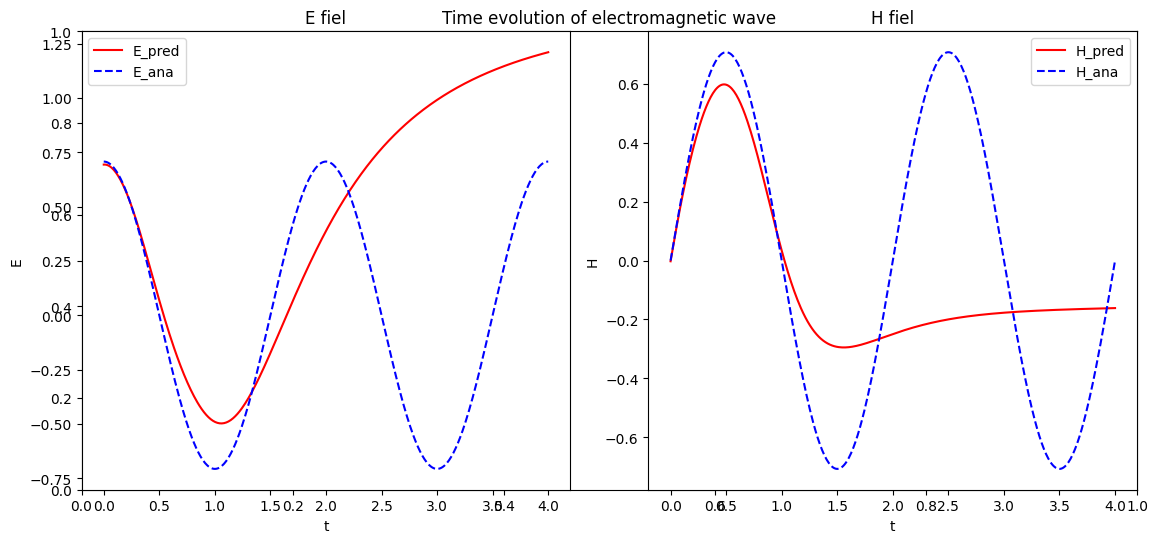

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

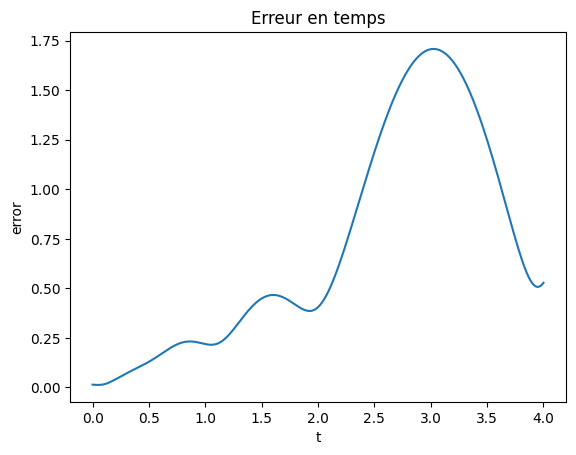

error_max in the trainning domain = [0.46674102]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Traninng2: epochs = 3000

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=3000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.100557 s

'compile' took 0.708288 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.12e-02, 1.73e-01, 3.19e-02, 4.39e-01, 3.60e-02]    [4.30e-02, 1.61e-01, 3.19e-02, 4.39e-01, 3.60e-02]    [1.09e+00]    
500       [1.74e-03, 2.05e-03, 1.58e-02, 2.29e-03, 8.35e-04]    [2.03e-03, 1.82e-03, 1.58e-02, 2.29e-03, 8.35e-04]    [4.69e-01]    
1000      [9.19e-04, 1.06e-03, 1.15e-02, 6.17e-04, 6.89e-05]    [1.08e-03, 1.19e-03, 1.15e-02, 6.17e-04, 6.89e-05]    [3.48e-01]    
1500      [1.11e-03, 9.71e-04, 7.06e-03, 2.12e-04, 1.76e-04]    [1.06e-03, 9.82e-04, 7.06e-03, 2.12e-04, 1.76e-04]    [2.53e-01]    
2000      [4.28e-04, 3.23e-04, 2.62e-03, 1.52e-04, 3.26e-05]    [5.14e-04, 4.18e-04, 2.62e-03, 1.52e-04, 3.26e-05]    [1.43e-01]    
2500      [2.64e-04, 1.65e-04, 7.16e-04, 6.62e-05, 2.30e-05]    [2.88e-0

# ***Time Evaluation***

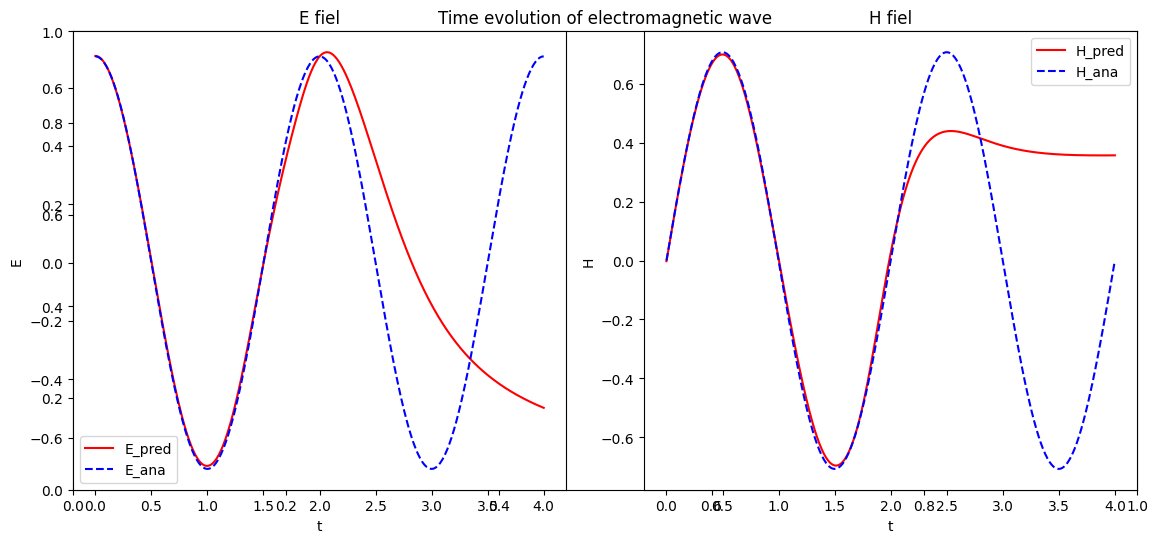

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

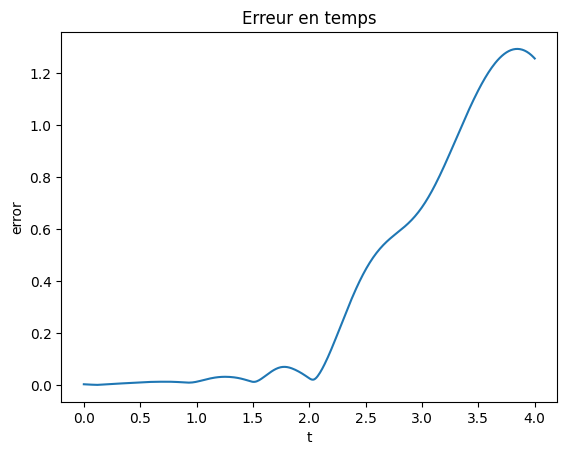

error_max in the trainning domain = [0.06958374]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning 3: epochs = 6000

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.094389 s

'compile' took 0.702236 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.13e-02, 1.73e-01, 3.22e-02, 4.39e-01, 3.60e-02]    [4.30e-02, 1.61e-01, 3.22e-02, 4.39e-01, 3.60e-02]    [1.08e+00]    
500       [2.23e-03, 1.98e-03, 1.50e-02, 3.05e-03, 1.32e-03]    [2.56e-03, 1.78e-03, 1.50e-02, 3.05e-03, 1.32e-03]    [4.80e-01]    
1000      [9.53e-04, 1.23e-03, 1.11e-02, 5.53e-04, 1.07e-04]    [1.10e-03, 1.28e-03, 1.11e-02, 5.53e-04, 1.07e-04]    [3.52e-01]    
1500      [8.05e-04, 8.07e-04, 7.56e-03, 3.85e-04, 1.05e-04]    [9.44e-04, 9.25e-04, 7.56e-03, 3.85e-04, 1.05e-04]    [2.79e-01]    
2000      [4.21e-04, 3.65e-04, 2.69e-03, 1.43e-04, 8.54e-05]    [4.84e-04, 4.44e-04, 2.69e-03, 1.43e-04, 8.54e-05]    [1.54e-01]    
2500      [3.93e-04, 2.36e-04, 8.26e-04, 1.29e-04, 4.23e-05]    [4.54e-0

# ***Time Evaluation***

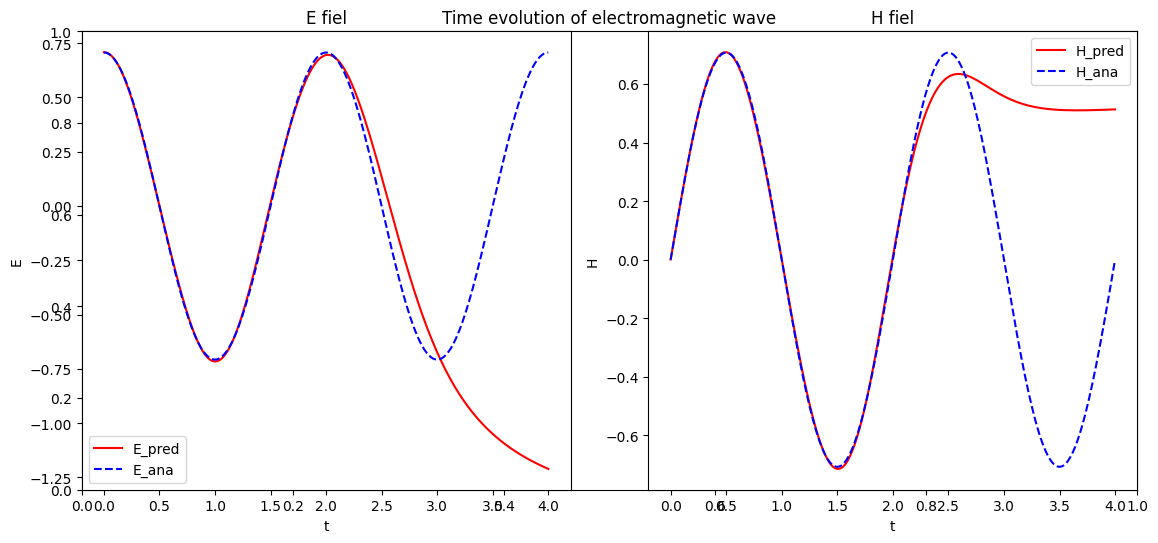

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

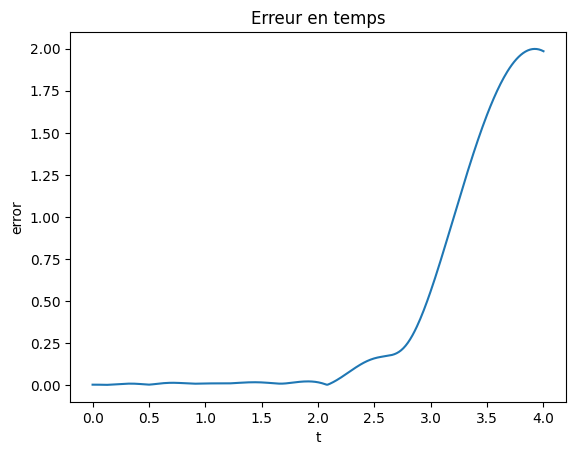

error_max in the trainning domain = [0.02111822]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainnig 4: epochs = 12000

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=12000, display_every=1000)


Compiling model...
Building feed-forward neural network...
'build' took 0.097195 s

'compile' took 0.781447 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [4.12e-02, 1.73e-01, 3.05e-02, 4.39e-01, 3.60e-02]    [4.30e-02, 1.61e-01, 3.05e-02, 4.39e-01, 3.60e-02]    [1.08e+00]    
1000      [8.52e-04, 1.03e-03, 1.09e-02, 6.27e-04, 6.09e-05]    [1.00e-03, 1.15e-03, 1.09e-02, 6.27e-04, 6.09e-05]    [3.40e-01]    
2000      [5.41e-04, 4.83e-04, 2.75e-03, 4.89e-04, 5.05e-05]    [5.50e-04, 4.94e-04, 2.75e-03, 4.89e-04, 5.05e-05]    [1.48e-01]    
3000      [1.42e-04, 1.06e-04, 4.96e-04, 2.61e-05, 2.81e-05]    [1.52e-04, 1.17e-04, 4.96e-04, 2.61e-05, 2.81e-05]    [6.89e-02]    
4000      [5.21e-05, 3.48e-05, 1.12e-04, 6.96e-06, 8.34e-06]    [6.29e-05, 3.24e-05, 1.12e-04, 6.96e-06, 8.34e-06]    [2.87e-02]    
5000      [2.84e-05, 2.40e-05, 4.55e-05, 7.79e-06, 2.81e-06]    [3.26e-0

# ***Time Evaluation***

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot Error

In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

error = []
x2 = np.linspace(0, 8, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max = {max(error)}")

# Plot result

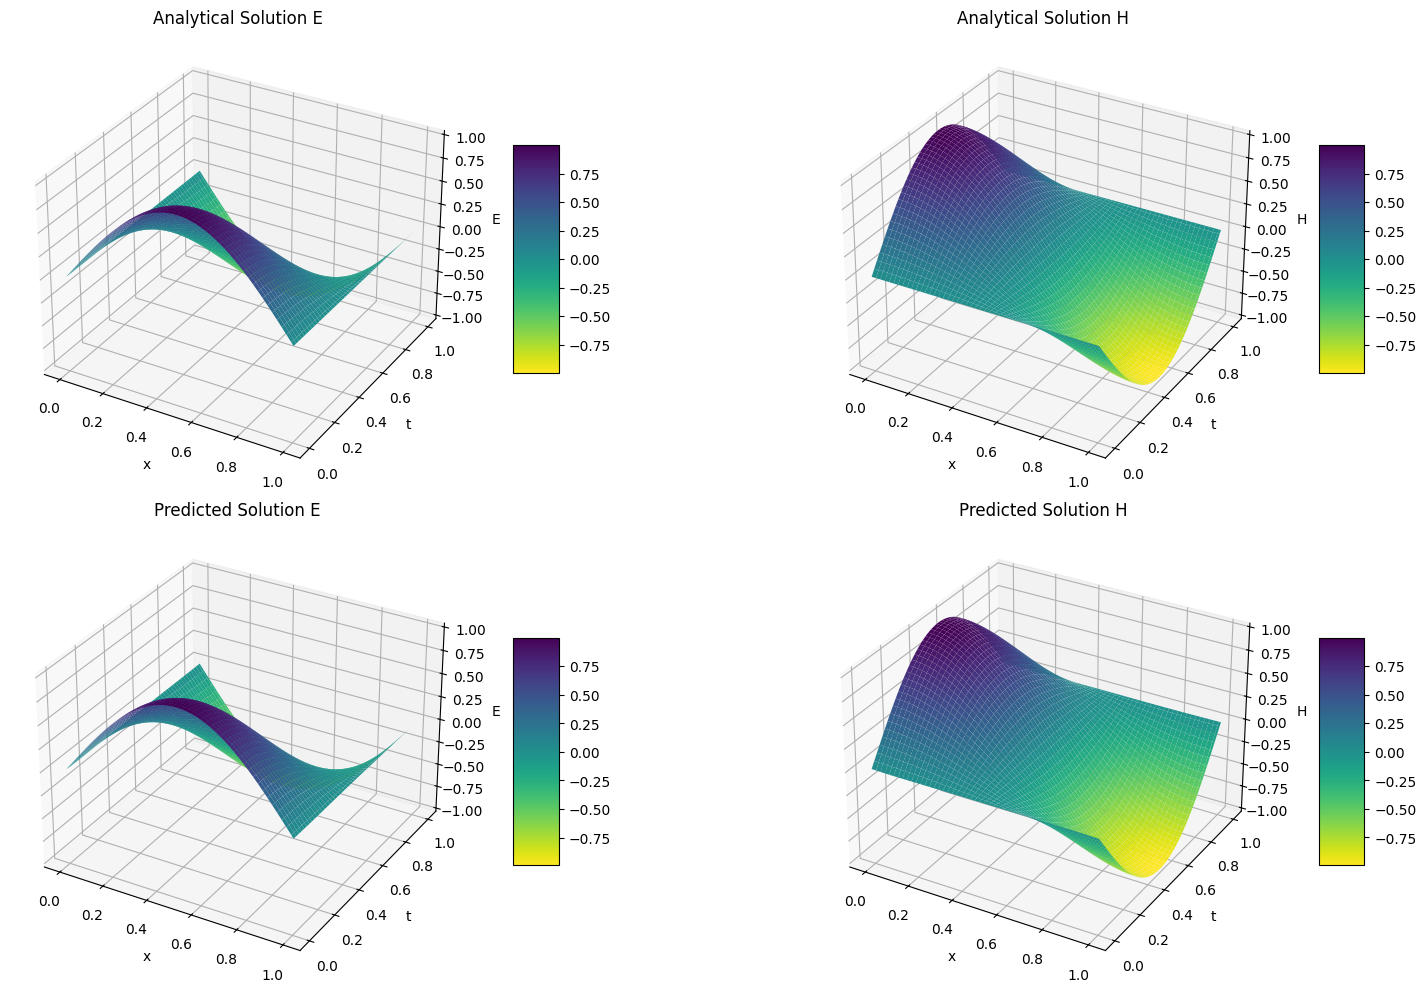

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

E_ex, H_ex = analy_sol(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))).T
E_ex = E_ex.reshape(X.shape)
H_ex = H_ex.reshape(X.shape)

E_pred, H_pred = model.predict(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))).T
E_pred = E_pred.reshape(X.shape)
H_pred = H_pred.reshape(X.shape)

fig = plt.figure(figsize=(18, 10))

#E
ax1 = fig.add_subplot(221, projection='3d')
E_ex = ax1.plot_surface(X, T, E_ex, cmap='viridis_r', edgecolor='none')
ax1.set_title('Analytical Solution E')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('E')
fig.colorbar(E_ex, ax=ax1, shrink=0.5, aspect=5)

# H
ax2 = fig.add_subplot(222, projection='3d')
H_ex = ax2.plot_surface(X, T, H_ex, cmap='viridis_r', edgecolor='none')
ax2.set_title('Analytical Solution H')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('H')
fig.colorbar(H_ex, ax=ax2, shrink=0.5, aspect=5)

# prediction of E
ax3 = fig.add_subplot(223, projection='3d')
E_pred = ax3.plot_surface(X, T, E_pred, cmap='viridis_r', edgecolor='none')
ax3.set_title('Predicted Solution E')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('E')
fig.colorbar(E_pred, ax=ax3, shrink=0.5, aspect=5)
# prediction of H
ax4 = fig.add_subplot(224, projection='3d')
H_pred = ax4.plot_surface(X, T, H_pred, cmap='viridis_r', edgecolor='none')
ax4.set_title('Predicted Solution H')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_zlabel('H')
fig.colorbar(H_pred, ax=ax4, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

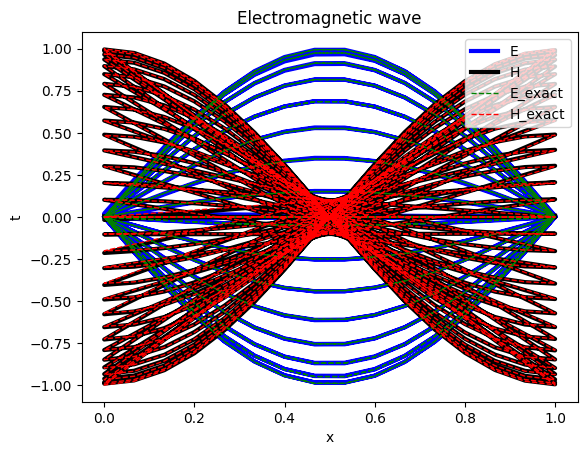

In [ ]:
x = geomtime.uniform_points(500)
y = model.predict(x)
fig, ax = plt.subplots()
ax.plot(x[:, 0], y[:, 0], color = 'b', lw = '3', label="E")
ax.plot(x[:, 0], y[:, 1], color = 'black', lw = '3', label="H")
ax.plot(x[:, 0], analy_sol(x)[:, 0], "g--", lw = '1', label="E_exact")
ax.plot(x[:, 0], analy_sol(x)[:, 1], "r--", lw = '1', label="H_exact")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Electromagnetic wave")
ax.legend()
plt.show()


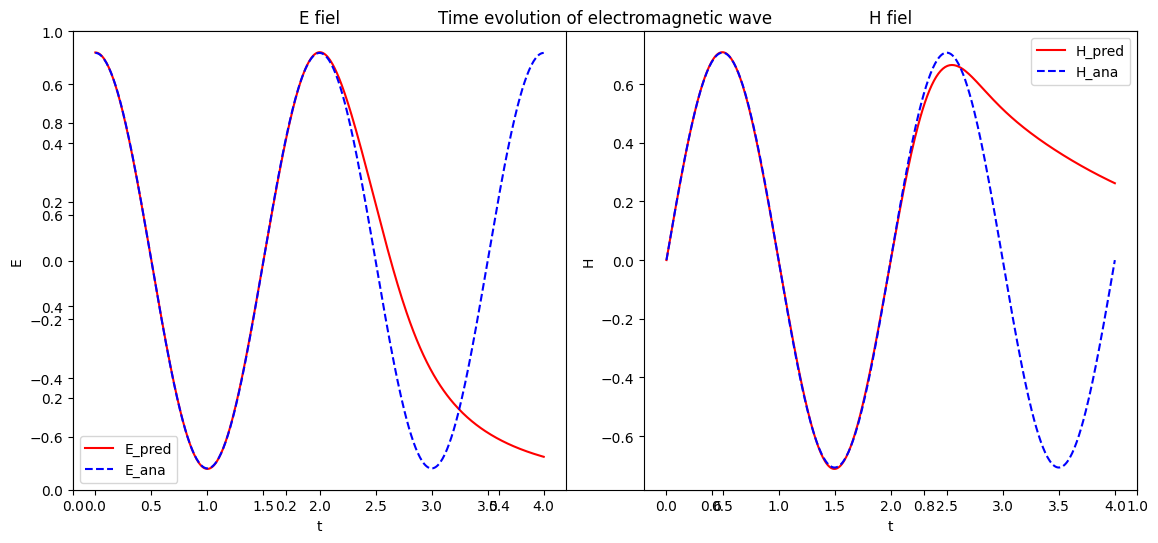

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

# ***Part3 : Neuron NetWork Trainning  num_domain=1000, num_boundary=100 num_initial=100, num_test=300， 6000 epochs***
# Trainning 1: 2 layers and 20 Nerons

In [ ]:
layer_size = [2] + [20] * 2 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.064816 s

'compile' took 0.724761 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [2.11e-02, 2.53e-01, 4.94e-02, 6.60e-01, 5.26e-05]    [1.76e-02, 2.12e-01, 4.94e-02, 6.60e-01, 5.26e-05]    [1.42e+00]    
500       [4.21e-03, 8.57e-03, 4.01e-02, 7.42e-02, 6.30e-03]    [2.73e-03, 5.95e-03, 4.01e-02, 7.42e-02, 6.30e-03]    [8.56e-01]    
1000      [4.44e-03, 4.15e-03, 2.57e-02, 1.15e-02, 1.24e-04]    [4.08e-03, 4.33e-03, 2.57e-02, 1.15e-02, 1.24e-04]    [6.66e-01]    
1500      [2.16e-03, 2.32e-03, 1.69e-02, 3.51e-03, 8.88e-04]    [2.14e-03, 2.36e-03, 1.69e-02, 3.51e-03, 8.88e-04]    [5.08e-01]    
2000      [1.09e-03, 1.37e-03, 1.40e-02, 1.47e-03, 4.90e-04]    [1.19e-03, 1.28e-03, 1.40e-02, 1.47e-03, 4.90e-04]    [4.19e-01]    
2500      [9.14e-04, 1.17e-03, 1.22e-02, 8.47e-04, 1.60e-04]    [1.01e-0

# ***Time Evaluation***

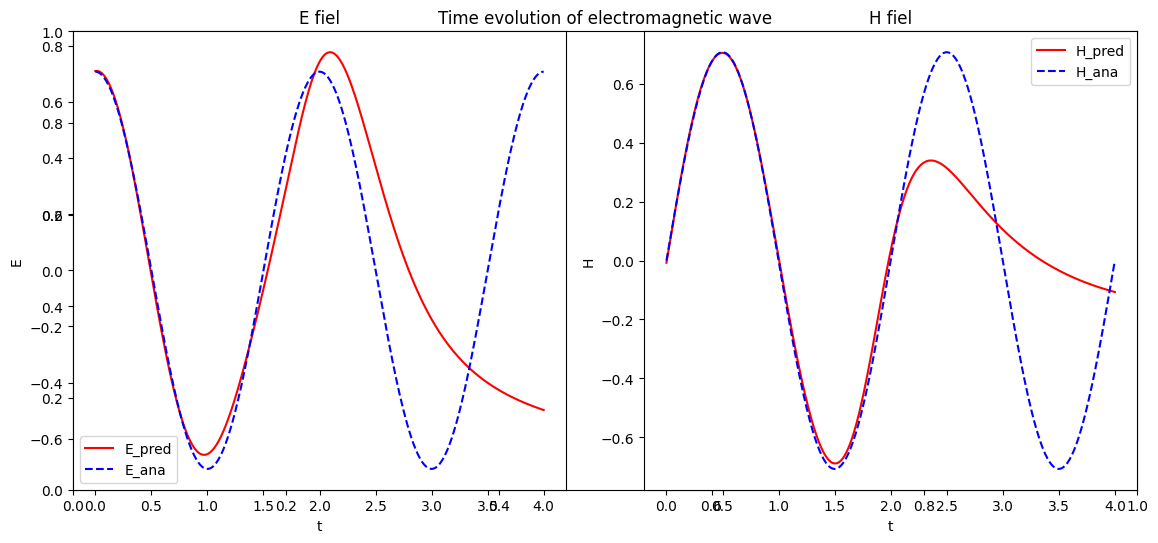

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

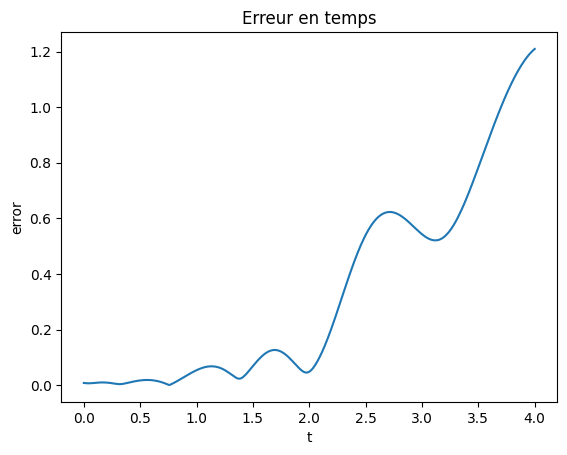

error_max in the trainning domain = [0.12667457]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# Trainning 2 : 2 layers and 50 Nerons

In [ ]:
layer_size = [2] + [50] * 2 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

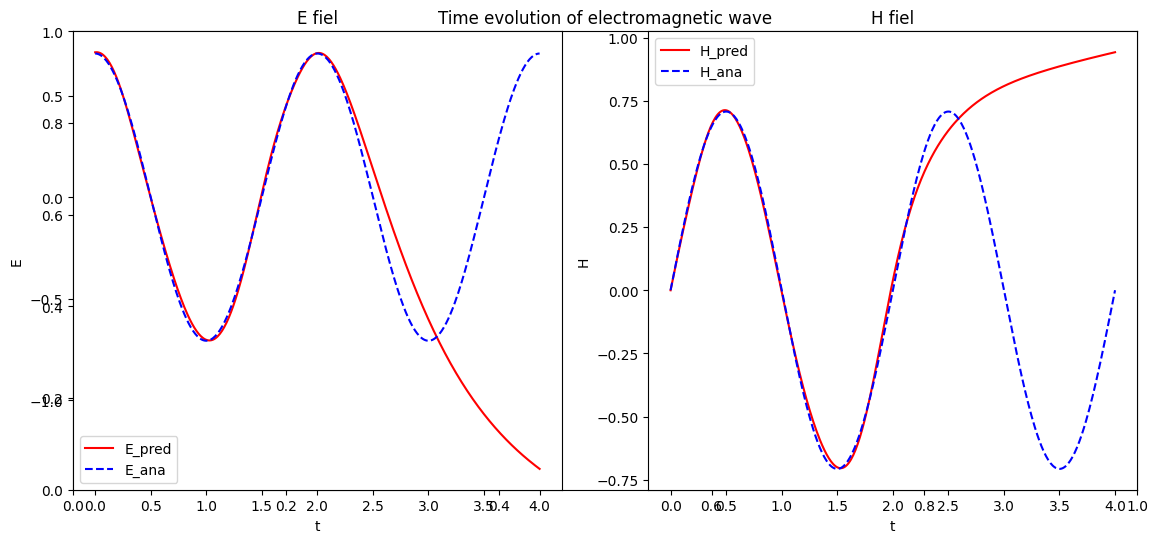

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

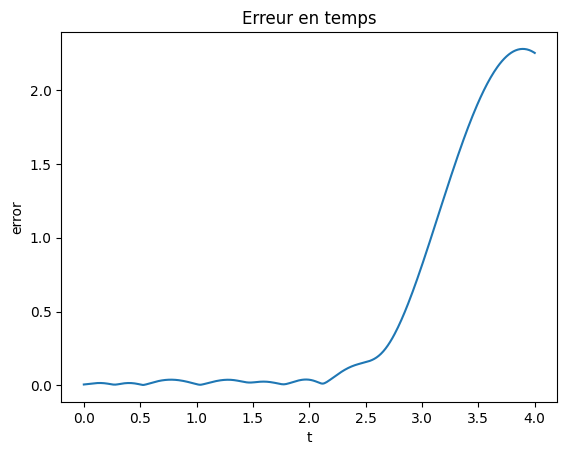

error_max in the trainning domain = [0.03961236]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 3 : 3 layers and 20 Nerons***

In [ ]:
layer_size = [2] + [20] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

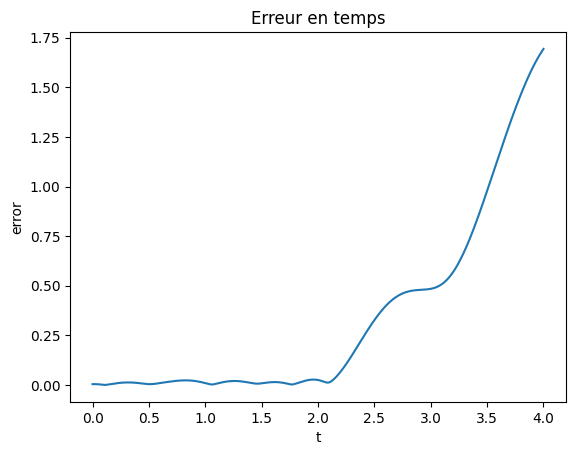

error_max in the trainning domain = [0.02742402]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 4 : 3 layers and 50 Nerons***

In [ ]:
layer_size = [2] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

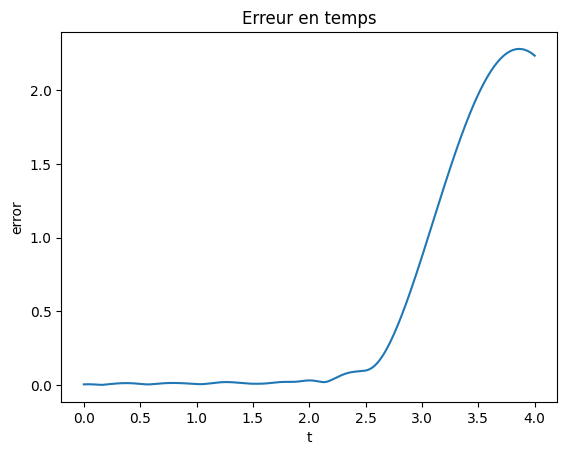

error_max in the trainning domain = [0.0314039]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 5 : 4 layers and 20 Nerons***

In [ ]:
layer_size = [2] + [20] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

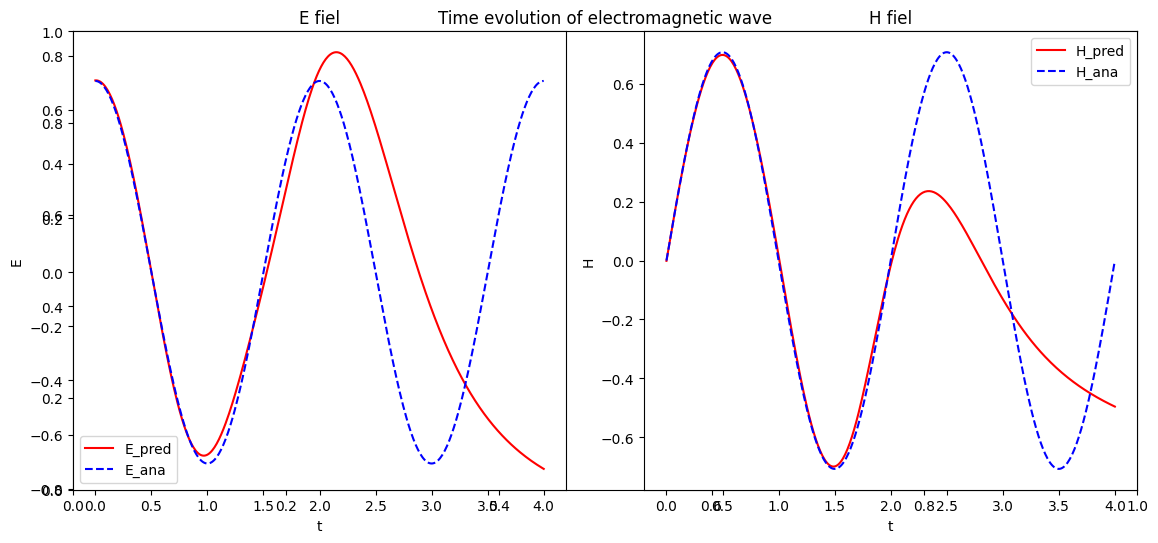

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

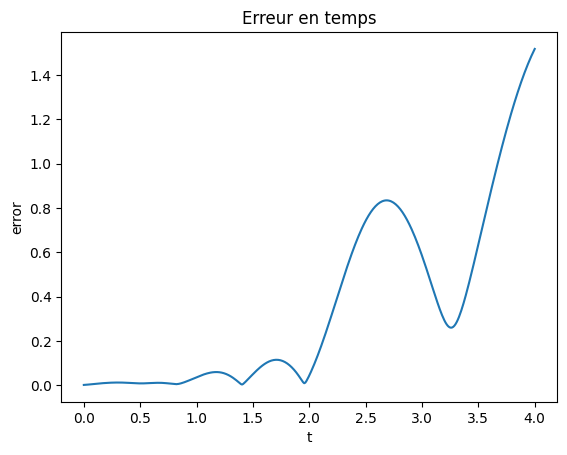

error_max in the trainning domain = [0.11559969]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 6 : 4 layers and 50 Nerons***

In [ ]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

# ***Time Evaluation***

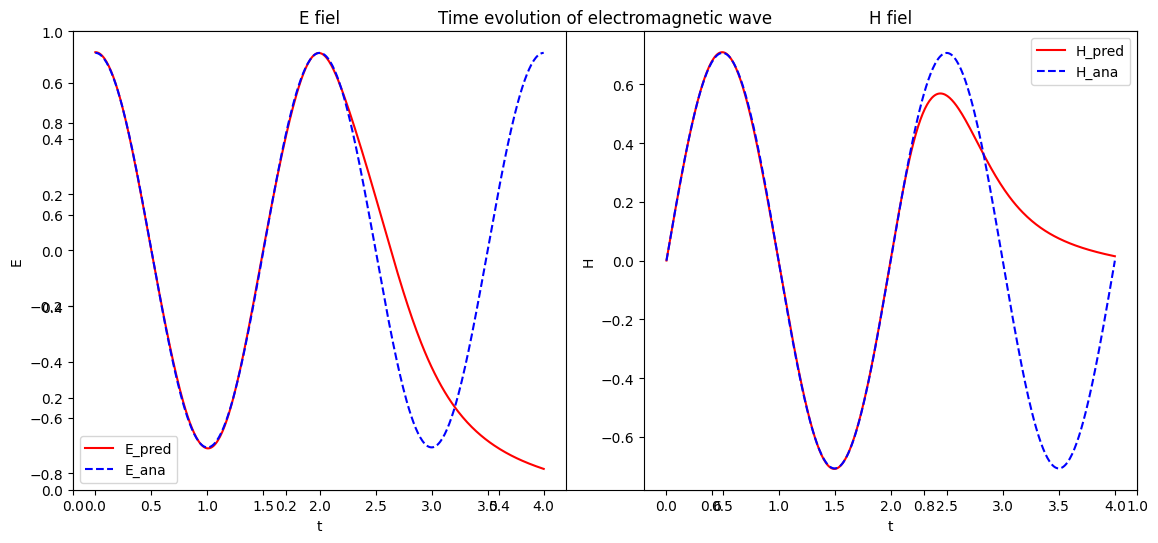

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

## Plot error

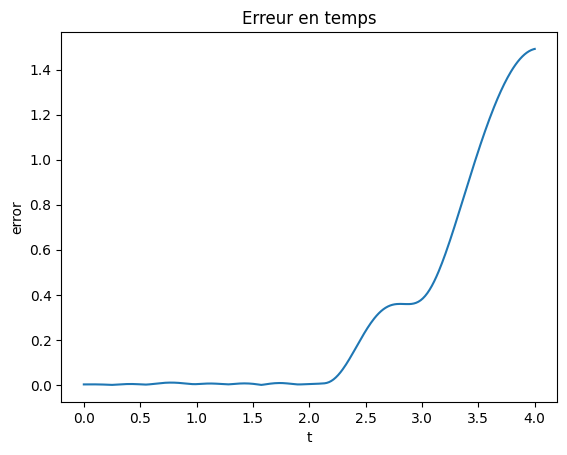

error_max in the trainning domain = [0.01043868]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")

# ***Trainning 7 : 4 layers and 80 Nerons***

In [ ]:
layer_size = [2] + [80] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, ic_E, ic_H],
    num_domain=1000,
    num_boundary=100,
    num_initial=100,
    num_test=300,
    solution = analy_sol
)

# Define and train model
model = dde.Model(data, net)
optimizer = "adam"
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=6000, display_every=500)

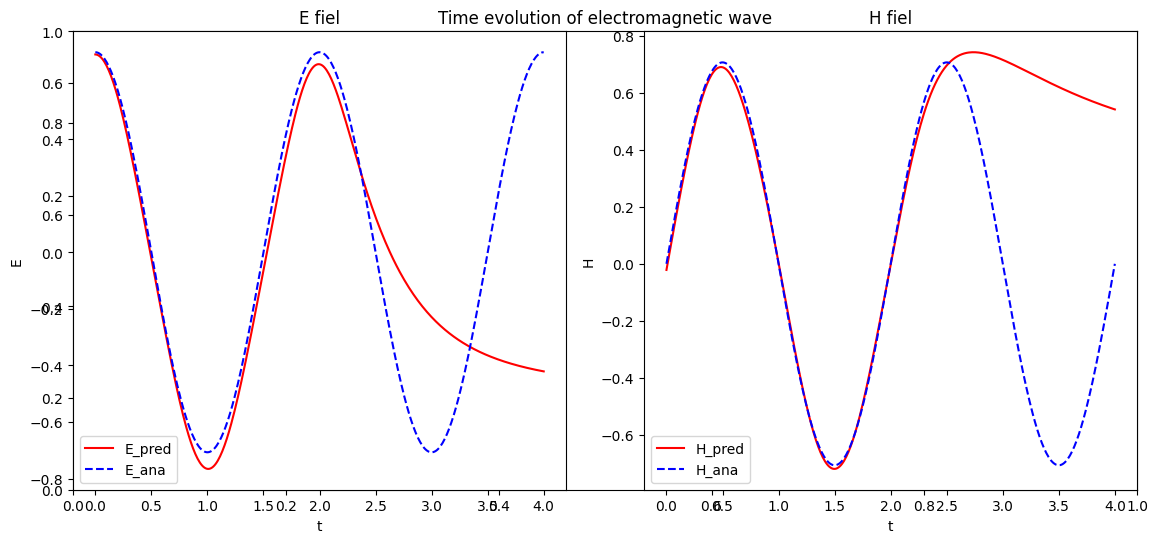

In [ ]:
# visualization
T = 2 * np.pi / omega
x_value = 0.25  # fixed point
x2 = np.linspace(0, 2 * T, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]

E_ana = analy_sol(x)[:, 0:1]
H_ana = analy_sol(x)[:, 1:2]

plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.plot(x2, E_ana, 'b--', label="E_ana")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.plot(x2, H_ana, 'b--', label="H_ana")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

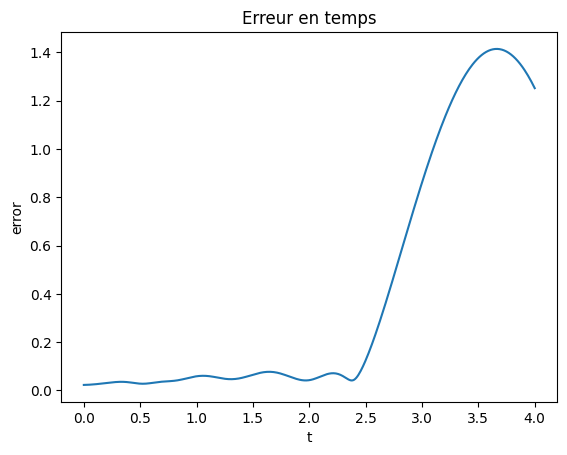

error_max in the trainning domain = [0.07721327]


In [ ]:
error = []
x2 = np.linspace(0, 4, 400)
for t in x2: # a chaque l'instan, on calcule l'erreur
  x = np.column_stack([x_value, t])
  y = model.predict(x)
  E_field = y[0, 0:1]
  H_field = y[0, 1:2]

  E_ana = analy_sol(x)[0, 0:1]
  H_ana = analy_sol(x)[0, 1:2]

  error_E = np.abs(E_field - E_ana) # erreur sur champs electriques
  error_H = np.abs(H_field - H_ana) # erreur sur champs magntiques
  error.append(np.sqrt(error_E**2 + error_H**2))
  #print(error)
plt.figure()
plt.plot(x2, error)
plt.xlabel("t")
plt.ylabel("error")
plt.title('Erreur en temps')
plt.show()
print(f"error_max in the trainning domain = {max(error[0:200])}")